In [1]:
import torch, torchvision
import numpy as np
from torch import nn
from pathlib import Path
import os
import random
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from timeit import default_timer as timer

c:\Users\18raj\AppData\Local\Programs\Python\Python37\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_path = Path("./data/train")
train_path_list = list(train_path.glob("*/*.jpg"))

val_path = Path("./data/val")
val_path_list = list(val_path.glob("*/*.jpg"))

test_path = Path("./data/test")
test_path_list = list(test_path.glob("*/*.jpg"))

print("Length of Dataset")
print(f"Train Data: {len(train_path_list)}")
print(f"Validation Data: {len(val_path_list)}")
print(f"Test Data: {len(test_path_list)}")

Length of Dataset
Train Data: 45000
Validation Data: 15000
Test Data: 15000


In [3]:
transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [4]:
train_data = datasets.ImageFolder(root=train_path, transform=transform, target_transform=None)
val_data = datasets.ImageFolder(root=val_path, transform=transform, target_transform=None)
test_data = datasets.ImageFolder(root=test_path, transform=transform, target_transform=None)

In [5]:
train_dataloader = DataLoader(dataset=train_data,
                            batch_size=32,
                            num_workers=os.cpu_count(),
                            shuffle=True)
val_dataloader = DataLoader(dataset=val_data,
                            batch_size=32,
                            num_workers=os.cpu_count(),
                            shuffle=True)
test_dataloader = DataLoader(dataset=test_data,
                            batch_size=32,
                            num_workers=os.cpu_count(),
                            shuffle=True)

In [6]:
class Model(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape, dropout_size):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*13*13, out_features=output_shape)
        )
        self.dropout = nn.Dropout(dropout_size)
    
    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.dropout(x)
        x = self.conv_block_2(x)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

In [7]:
model1 = Model(input_shape=3, hidden_units=10, output_shape=len(train_data.classes), dropout_size=0.25)
print(model1.parameters())

<generator object Module.parameters at 0x0000020B2008A1C8>


In [8]:
def train(model: nn.Module,
        loss_fn: nn.Module,
        optimizer: torch.optim.Optimizer,
        dataloader: torch.utils.data.DataLoader,
        device="cpu"
    ):
    model.train()
    train_loss, accuracy = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        accuracy += (y_pred_class == y).sum().item()/len(y_pred)
    train_loss = train_loss/len(dataloader)
    accuracy = accuracy/len(dataloader)
    return train_loss, accuracy

In [9]:
def test(model: nn.Module,
        loss_fn: nn.Module,
        dataloader: torch.utils.data.DataLoader,
        device="cpu"
    ):
    model.eval()
    test_loss, accuracy = 0, 0
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            
            y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            accuracy += (y_pred_class == y).sum().item()/len(y_pred)
    test_loss = test_loss/len(dataloader)
    accuracy = accuracy/len(dataloader)
    return test_loss, accuracy

In [10]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model1.parameters(), lr=0.001)

In [11]:
results = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": []
}

start_time = timer()
epochs = 10
for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train(model=model1,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test(model=model1,
                                    dataloader=val_dataloader,
                                    loss_fn=loss_fn)
    
    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.4f}")
    results["train_loss"].append(train_loss)
    results["train_accuracy"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_accuracy"].append(test_acc)

end_time = timer()
print(f"Total Training Time: {end_time-start_time:.3f}")

 10%|█         | 1/10 [23:31<3:31:46, 1411.83s/it]

Epoch: 0 | Train Loss: 1.5972 | Train Acc: 0.2283 | Test Loss: 1.5641 | Test Acc: 0.1999


 20%|██        | 2/10 [48:21<3:14:21, 1457.64s/it]

Epoch: 1 | Train Loss: 0.9437 | Train Acc: 0.6000 | Test Loss: 0.7960 | Test Acc: 0.5714


 30%|███       | 3/10 [1:04:11<2:23:01, 1225.99s/it]

Epoch: 2 | Train Loss: 0.4154 | Train Acc: 0.8458 | Test Loss: 0.2617 | Test Acc: 0.9247


 40%|████      | 4/10 [1:21:57<1:56:15, 1162.62s/it]

Epoch: 3 | Train Loss: 0.3344 | Train Acc: 0.8792 | Test Loss: 0.2269 | Test Acc: 0.9241


 50%|█████     | 5/10 [1:29:02<1:14:44, 896.85s/it] 

Epoch: 4 | Train Loss: 0.2779 | Train Acc: 0.9008 | Test Loss: 0.1845 | Test Acc: 0.9398


 60%|██████    | 6/10 [1:34:47<47:16, 709.12s/it]  

Epoch: 5 | Train Loss: 0.2446 | Train Acc: 0.9140 | Test Loss: 0.2003 | Test Acc: 0.9265


 70%|███████   | 7/10 [1:40:27<29:25, 588.50s/it]

Epoch: 6 | Train Loss: 0.2169 | Train Acc: 0.9239 | Test Loss: 0.1450 | Test Acc: 0.9512


 80%|████████  | 8/10 [1:45:41<16:41, 500.88s/it]

Epoch: 7 | Train Loss: 0.2005 | Train Acc: 0.9285 | Test Loss: 0.1496 | Test Acc: 0.9471


 90%|█████████ | 9/10 [1:50:48<07:20, 440.36s/it]

Epoch: 8 | Train Loss: 0.1878 | Train Acc: 0.9334 | Test Loss: 0.1961 | Test Acc: 0.9299


100%|██████████| 10/10 [1:56:21<00:00, 698.11s/it]

Epoch: 9 | Train Loss: 0.1778 | Train Acc: 0.9363 | Test Loss: 0.1279 | Test Acc: 0.9572


Total Training Time: 6981.840


In [12]:
def plot_loss_curves(results: Dict[str, List[float]]):
    loss = results["train_loss"]
    test_loss = results["test_loss"]
    acc = results["train_accuracy"]
    test_acc = results["test_accuracy"]
    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, label="Train Accuracy")
    plt.plot(epochs, test_acc, label="Test Accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

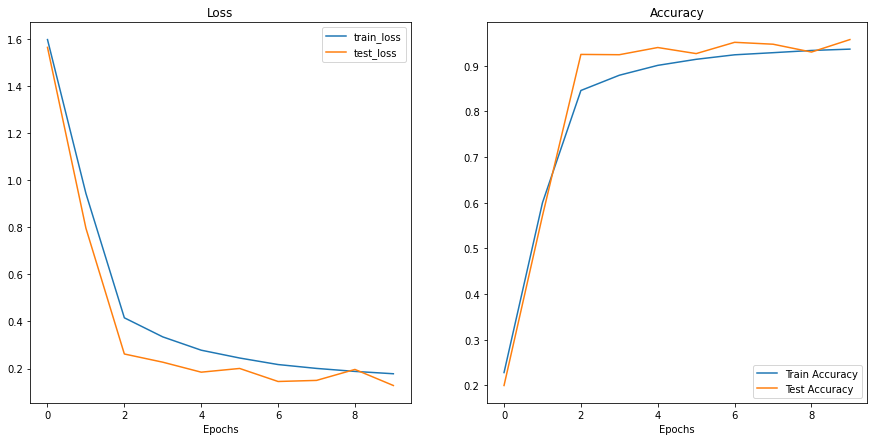

In [13]:
plot_loss_curves(results)

In [14]:
MODEL_PATH = Path(".")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "model-sgd-noaug"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving Model to {MODEL_SAVE_PATH}")
torch.save(obj=model1.state_dict(), f=MODEL_SAVE_PATH)

Saving Model to model-sgd-noaug


In [15]:
test_loss, test_acc = test(model=model1,
                        dataloader=test_dataloader,
                        loss_fn=loss_fn)
print("Final Results.....")
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f}")

Final Results.....
Test Loss: 0.1292 | Test Accuracy: 0.9580
